# 1. Data

In [11]:
from keras.datasets import mnist
(data_x, data_y), (test_x, test_y) = mnist.load_data()


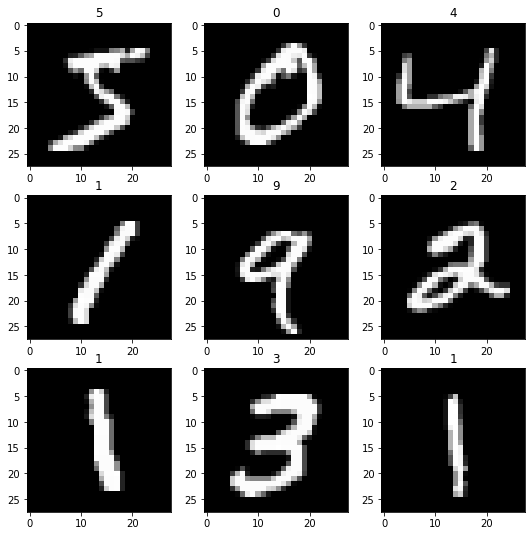

In [12]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i in range(9):
    row = i//3
    column = i % 3
    axs[row][column].imshow(data_x[i], cmap="gray")
    axs[row][column].set_title(data_y[i])
plt.show()


# 2. Preprocess data

In [13]:
data_x = data_x/255.0
test_x = test_x/255.0


In [14]:
from sklearn.model_selection import KFold
# Split the dataset. Random_state is seed
# train_x, val_x, train_y, val_y = train_test_split(
#     train_x, train_y, test_size=0.2, random_state=42)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [15]:
import torch
class Data(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.x = data
        self.y = label

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [16]:
# train, val = Data(train_x, train_y), Data(val_x, val_y)
# train_dataloader = torch.utils.data.DataLoader(train, batch_size=32)
# val_dataloader = torch.utils.data.DataLoader(val, batch_size=32)

# 3. Build model

In [17]:
from torch import nn


class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(28*28, 32)
        # 10 is out_feature, corresponds to digits 0->9
        # 28 is size of dataset
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)  # Stretch array of 28*28 to 1*724
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x


# 4. Train

In [18]:
model = SimpleModel()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model = model.to(device)
criterion = criterion.to(device)


In [19]:
from tqdm import tqdm
import numpy as np
min_val_loss = 100000000000
# for epoch in range(10):
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(data_x)))):
    train = Data(data_x[train_idx], data_y[train_idx])
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=32)
    val = Data(data_x[val_idx], data_y[val_idx])
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=32)
    
    total_loss_train = 0
    total_acc_train = 0
    for x, y in tqdm(train_dataloader):
        x = x.to(device)
        y = y.to(device)

        output = model(x.float())

        batch_loss = criterion(output, y)
        total_loss_train += batch_loss

        acc = (output.argmax(dim=1) == y).sum().item()
        total_acc_train += acc

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_loss_val = 0
    total_acc_val = 0
    with torch.no_grad():  # Not training
        for x, y in tqdm(val_dataloader):
            x = x.to(device)
            y = y.to(device)

            output = model(x.float())

            batch_loss = criterion(output, y)
            total_loss_val += batch_loss.item()

            acc = (output.argmax(dim=1) == y).sum().item()
            total_acc_val += acc
    print(
        f'''Epochs: {fold+1} 
        | Train Loss: {total_loss_train / len(train):.3f}
        | Train Accuracy: {total_acc_train/len(train):.3f}
        | Val Loss: {total_loss_val/len(val):.3f}
        | Val Accuracy: {total_acc_val/len(val):.3f}
        | Train idx: {train_idx}
        | Val idx: {val_idx}'''
    )
    if min_val_loss > total_loss_val/len(val):
        min_val_loss = total_loss_val/len(val)
        torch.save(model.state_dict(), "simplemodel.pt")
        print(f"Save model because val loss improve loss {min_val_loss:.3f}")


100%|██████████| 188/188 [00:00<00:00, 1027.30it/s]


Epochs: 1 
        | Train Loss: 0.013
        | Train Accuracy: 0.888
        | Val Loss: 0.008
        | Val Accuracy: 0.926
        | Train idx: [    0     1     2 ... 59996 59997 59998]
        | Val idx: [    4     6     7 ... 59981 59989 59999]
Save model because val loss improve loss 0.008


100%|██████████| 188/188 [00:00<00:00, 1038.68it/s]


Epochs: 2 
        | Train Loss: 0.007
        | Train Accuracy: 0.934
        | Val Loss: 0.006
        | Val Accuracy: 0.940
        | Train idx: [    0     1     2 ... 59997 59998 59999]
        | Val idx: [   32    41    71 ... 59980 59983 59984]
Save model because val loss improve loss 0.006


100%|██████████| 188/188 [00:00<00:00, 924.43it/s]


Epochs: 3 
        | Train Loss: 0.006
        | Train Accuracy: 0.948
        | Val Loss: 0.006
        | Val Accuracy: 0.949
        | Train idx: [    0     1     2 ... 59997 59998 59999]
        | Val idx: [   11    30    31 ... 59972 59973 59992]
Save model because val loss improve loss 0.006


100%|██████████| 188/188 [00:00<00:00, 1050.31it/s]


Epochs: 4 
        | Train Loss: 0.005
        | Train Accuracy: 0.956
        | Val Loss: 0.004
        | Val Accuracy: 0.960
        | Train idx: [    2     3     4 ... 59997 59998 59999]
        | Val idx: [    0     1    13 ... 59985 59987 59995]
Save model because val loss improve loss 0.004


100%|██████████| 188/188 [00:00<00:00, 1062.13it/s]


Epochs: 5 
        | Train Loss: 0.004
        | Train Accuracy: 0.962
        | Val Loss: 0.004
        | Val Accuracy: 0.957
        | Train idx: [    0     1     2 ... 59997 59998 59999]
        | Val idx: [   25    46    47 ... 59978 59986 59990]


100%|██████████| 188/188 [00:00<00:00, 1038.59it/s]


Epochs: 6 
        | Train Loss: 0.004
        | Train Accuracy: 0.965
        | Val Loss: 0.003
        | Val Accuracy: 0.968
        | Train idx: [    0     1     2 ... 59995 59996 59999]
        | Val idx: [    3     8    14 ... 59988 59997 59998]
Save model because val loss improve loss 0.003


100%|██████████| 188/188 [00:00<00:00, 1050.31it/s]


Epochs: 7 
        | Train Loss: 0.003
        | Train Accuracy: 0.969
        | Val Loss: 0.003
        | Val Accuracy: 0.969
        | Train idx: [    0     1     2 ... 59997 59998 59999]
        | Val idx: [   18    19    24 ... 59965 59969 59974]
Save model because val loss improve loss 0.003


100%|██████████| 188/188 [00:00<00:00, 1092.86it/s]


Epochs: 8 
        | Train Loss: 0.003
        | Train Accuracy: 0.971
        | Val Loss: 0.003
        | Val Accuracy: 0.969
        | Train idx: [    0     1     2 ... 59997 59998 59999]
        | Val idx: [    5    15    20 ... 59991 59993 59994]
Save model because val loss improve loss 0.003


100%|██████████| 188/188 [00:00<00:00, 1074.29it/s]


Epochs: 9 
        | Train Loss: 0.003
        | Train Accuracy: 0.973
        | Val Loss: 0.003
        | Val Accuracy: 0.968
        | Train idx: [    0     1     3 ... 59997 59998 59999]
        | Val idx: [    2    10    12 ... 59954 59963 59982]


100%|██████████| 188/188 [00:00<00:00, 1044.45it/s]

Epochs: 10 
        | Train Loss: 0.003
        | Train Accuracy: 0.976
        | Val Loss: 0.002
        | Val Accuracy: 0.973
        | Train idx: [    0     1     2 ... 59997 59998 59999]
        | Val idx: [    9    55    60 ... 59975 59976 59996]
Save model because val loss improve loss 0.002


# 5. Tests

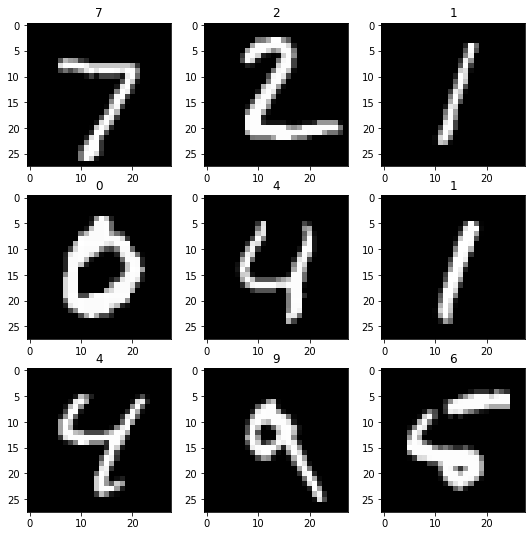

In [20]:
model = SimpleModel()
model = model.to(device)
model.load_state_dict(torch.load("simplemodel.pt"))

test_x = torch.tensor(test_x).to(device)
test_y = torch.tensor(test_y).to(device)
(model(test_x.float()).argmax(dim=1)==test_y).sum().item()/test_y.shape[0]

fig, axs = plt.subplots(3, 3, figsize=(9,9))
for i in range(9):
  row = i//3
  column = i%3
  axs[row][column].imshow(test_x[i].cpu(), cmap="gray")
  axs[row][column].set_title(model(test_x[i:i+1].float()).argmax(dim=1)[0].item())
plt.show()